In [1]:
import pandas as pd
import numpy as np
import curvefit
from curvefit.model import CurveModel
from curvefit.utils import get_derivative_of_column_in_log_space, get_obs_se
from curvefit.utils import truncate_draws, data_translator, convex_combination

In [2]:
file_path_data = '../data/Slovakia.csv'
file_path_covariate = '../data/Slovakia covariate.csv'

df = pd.read_csv(file_path_data)
df_cov = pd.read_csv(file_path_covariate)

df_cov = df_cov.rename(columns={'location': 'Location'})
df = pd.merge(df, df_cov, on='Location', how='inner').copy()

df['intercept'] = 1.0
df = get_derivative_of_column_in_log_space(
    df,
    col_t='Days',
    col_obs='ln(age-standardized death rate)',
    col_grp='Location',
)
df['daily deaths'] = np.exp(df['d ln(age-standardized death rate)'])
df['obs_std_tight'] = 1 / (1.0 + df['Days'])
df['obs_std_loose'] = 1 / (0.1 + df['Days']**2)
df['obs_std_none'] = 0.01

df.to_csv('../data/Slovakia_combined.csv', index=False)
df.head()

#### Load data

In [3]:
df = pd.read_csv('../data/Slovakia_combined.csv')
df.head()

,location_id,Location,Country/Region_x,Date,Days,Deaths,Death rate,population,Implied death rate,Age-standardized death rate,...,composite_1w,composite_3w,cov_1w,cov_3w,intercept,d ln(age-standardized death rate),daily deaths,obs_std_tight,obs_std_loose,obs_std_none
0,35507,Abruzzo,Italy,2020-03-14,4.481815,2.0,0.000002,1.312214e+06,0.000015,9.551844e-07,...,-2.428571,-2.428571,0.714286,0.714286,1.0,-15.360065,2.134069e-07,0.182421,0.049538,0.01
1,35507,Abruzzo,Italy,2020-03-15,5.481815,3.0,0.000002,1.312214e+06,0.000015,1.432777e-06,...,-2.428571,-2.428571,0.714286,0.714286,1.0,-15.386896,2.077571e-07,0.154278,0.033167,0.01
2,35507,Abruzzo,Italy,2020-03-16,6.481815,4.0,0.000003,1.312214e+06,0.000015,1.910369e-06,...,-2.428571,-2.428571,0.714286,0.714286,1.0,-14.311038,6.092493e-07,0.133657,0.023745,0.01
3,35507,Abruzzo,Italy,2020-03-17,7.481815,6.0,0.000005,1.312214e+06,0.000015,2.865553e-06,...,-2.428571,-2.428571,0.714286,0.714286,1.0,-14.248731,6.484177e-07,0.117899,0.017832,0.01
4,35507,Abruzzo,Italy,2020-03-18,8.481815,7.0,0.000005,1.312214e+06,0.000015,3.343145e-06,...,-2.428571,-2.428571,0.714286,0.714286,1.0,-13.760265,1.056800e-06,0.105465,0.013881,0.01


#### Run on peaked group

In [4]:
peaked_group = [
    'Wuhan City, Hubei',
    'Piemonte',
    'Comunidad de Madrid',
    'Emilia-Romagna',
    'Toscana',
    'Liguria',
    'Lombardia',
    'King and Snohomish Counties (excluding Life Care Center), WA',
]

- create the model (no adjustment in std or prior modifier)

In [5]:
model_info_dict = dict(
    col_t='Days',
    col_obs='ln(age-standardized death rate)',
    col_covs=[['intercept'], ['cov_1w'], ['intercept']],
    col_group='Location',
    param_names=['alpha', 'beta', 'p'],
    link_fun=[np.exp, lambda x: x, np.exp],
    var_link_fun=[lambda x: x, lambda x: x, lambda x: x],
    fun=curvefit.log_erf,
    col_obs_se='obs_std_tight',
)

In [6]:
peaked_model = CurveModel(df[df['Location'].isin(peaked_group)], **model_info_dict)

- fit the model

In [7]:
dummy_gprior = [0.0, np.inf]
dummy_uprior = [-np.inf, np.inf]
zero_uprior = [0.0, 0.0]
fe_init = np.array([-3, 28.0, -8.05])
fe_bounds = [[-np.inf, 0.0], [15.0, 100.0], [-10, -6]]
options = {
    'ftol': 1e-10,
    'gtol': 1e-10,
    'maxiter': 500,
    'disp': True,
}

basic_model_fit_dict = dict(
    fe_gprior=[dummy_gprior]*3,
    re_bounds=[dummy_uprior]*3,
    re_gprior=[dummy_gprior, [0.0, 10.0], dummy_gprior],
    smart_initialize=True,
    smart_init_options=options,
    options={
        'ftol': 1e-10,
        'gtol': 1e-10,
        'maxiter': 10,
        'disp': True
    },
)

In [8]:
peaked_model.fit_params(fe_init, **basic_model_fit_dict)

Overriding fe_init with [-2.49472121 24.94638039 -8.51503884].
Overriding re_init with [-0.05845352  0.27565028  0.43756421 -0.2057905  -4.56488025 -0.57234887
  0.0808492   0.37928015  0.08715508 -0.05896036  1.81542475  1.18477236
  0.00597866  1.66004304 -0.07440037  0.41094309 -3.19493044 -1.4652553
 -0.17456658  3.62941247  0.40251289].


- compute Gaussian prior for beta based on fit

In [9]:
fe_peaked, re_peaked = peaked_model.unzip_x(peaked_model.result.x)
beta_fe_mean = fe_peaked[1]
beta_fe_std = np.std(re_peaked[:, 1])
print('beta mean', beta_fe_mean)
print('beta_fe_std', beta_fe_std)

beta mean 24.946389025697094
beta_fe_std 2.6845074001914395


#### Fit a specific location 

In [10]:
location = 'Basilicata'
# all_locations = np.unique(df['Location'].values)
# location = np.random.choice(all_locations)
print(location)
one_loc_model = CurveModel(df[df['Location'].isin([location])], **model_info_dict)

Basilicata


In [11]:
one_loc_fit_dict = basic_model_fit_dict.copy()

In [12]:
prior_modifier = lambda x: 10**(min(0.0, max(-1.0, 0.1*x - 1.5)))
one_loc_fit_dict['fe_gprior'] = [
    dummy_gprior, 
    [beta_fe_mean, prior_modifier(one_loc_model.num_obs) * beta_fe_std], 
    dummy_gprior,
]
one_loc_fit_dict['smart_initialize'] = False
one_loc_fit_dict['options']['maxiter'] = 50

In [13]:
one_loc_model.fit_params(fe_peaked, **one_loc_fit_dict)

- plot results for one location

In [14]:
import matplotlib.pyplot as plt
def plot_one_loc(t, model):
    fig, ax = plt.subplots(1, 2, figsize=(8*2, 4))
    y = model.fun(t, model.params[:, 0])
    ax[0].scatter(model.t, model.obs)
    ax[0].plot(t, y)
    ax[0].set_title(location)

    dy = curvefit.derf(t, model.params[:, 0])
    derf_obs = data_translator(
        model.obs,
        model_info_dict['fun'], 
        'derf',
    )
    ax[1].scatter(model.t, derf_obs)
    ax[1].plot(t, dy)
    ax[1].set_title(location)
    ax[1].set_ylim(0.0, max(dy.max(), derf_obs.max())*1.1)

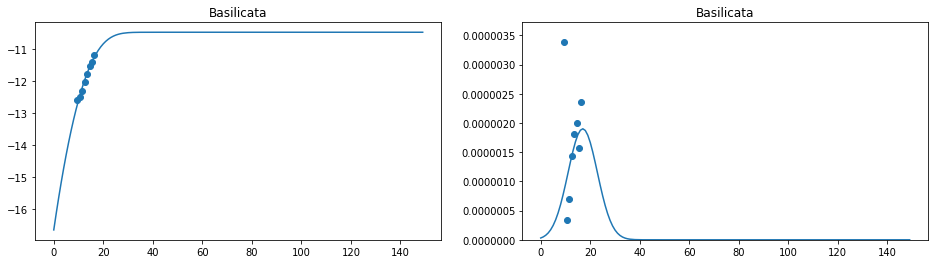

In [15]:
plot_one_loc(np.arange(150), one_loc_model)